## Eric Maxwell
## CSC 570R 
## Titanic Survival Predition with Logistic Regression
<hr style="height:5px">

We will be using the following variables:
+ Age
+ Sex
+ Fare
+ Family Members: Parch + SibSp 
+ Title: Derived from Name. Each name has a title associated with it.
+ Pclass
+ Cabin
+ Embarked

The dependent variable is Survived

<hr style="height:2px">
### Data Prep

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split

%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\eek00\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#Get data file and create data frame
df = pd.read_csv("train.csv")

In [3]:
#Display attribute variables
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [4]:
#Create new empty data frame
X = pd.DataFrame()

In [5]:
#Function which creates dummies for categorical variables
def get_dummies(df,variable):
    # Create array of dummies
    dummies = pd.get_dummies(df[variable], prefix=variable)
    # Update X to include dummies and drop the main variable
    df = pd.concat([df, dummies], axis=1)
    df.drop([variable], axis=1, inplace=True)
    return df

#### Get title from each name. Each name has a title associated with it. It occurs after the first comma and ends with a period.

In [6]:
#Get name title after first comma and ending with a period
X['title'] = df['Name'].map(lambda x: x.split(',')[1].split('.')[0].strip())

#### Check title counts

In [7]:
X.title.value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Col               2
Major             2
Jonkheer          1
the Countess      1
Don               1
Lady              1
Sir               1
Ms                1
Mme               1
Capt              1
Name: title, dtype: int64

#### Check the mean age for the most common titles

In [8]:
#Add the age variable to the data set
X['age'] = df['Age']

#Calculate mean age for the most common titles
T = ['Mr', 'Mrs', 'Miss', 'Ms', 'Master', 'Dr', 'Rev']
for t in T:
    print(t,"mean age: %0.1f" %X[X.title == t].age.mean())

Mr mean age: 32.4
Mrs mean age: 35.9
Miss mean age: 21.8
Ms mean age: 28.0
Master mean age: 4.6
Dr mean age: 42.0
Rev mean age: 43.2


##### There seems to be a correlation between age and title. We will use average age of the title for missing age values

In [9]:
#Fill missing ages with the mean age for the corresponding title
X['age'].fillna(X['title'].map(lambda x: X[X.title == x].age.mean()), inplace=True)

##### We will use total family members, which is the Parch and SibSp variables added together

In [10]:
#Total family members is the Parent/Children number plus the Sibling/Spouse number
X['family_members'] = df['Parch'] + df['SibSp']

##### Check common ticket values

In [11]:
#Get ticket value counts
df['Ticket'].value_counts()

1601                  7
347082                7
CA. 2343              7
347088                6
CA 2144               6
3101295               6
S.O.C. 14879          5
382652                5
PC 17757              4
LINE                  4
17421                 4
4133                  4
W./C. 6608            4
349909                4
113781                4
113760                4
19950                 4
2666                  4
347077                4
13502                 3
230080                3
347742                3
PC 17572              3
363291                3
239853                3
SC/Paris 2123         3
PC 17760              3
F.C.C. 13529          3
C.A. 34651            3
35273                 3
                     ..
350417                1
C.A. 17248            1
111320                1
349216                1
SOTON/O.Q. 3101306    1
233639                1
239855                1
3101267               1
231945                1
SOTON/OQ 3101316      1
113055          

##### Check names for a ticket with multiple passengers

In [12]:
#Check last names of a ticket associated with several passengers
df[df.Ticket == "347082"]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
13,14,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.275,NaN,S
119,120,0,3,"Andersson, Miss. Ellis Anna Maria",female,2.0,4,2,347082,31.275,NaN,S
541,542,0,3,"Andersson, Miss. Ingeborg Constanzia",female,9.0,4,2,347082,31.275,NaN,S
542,543,0,3,"Andersson, Miss. Sigrid Elisabeth",female,11.0,4,2,347082,31.275,NaN,S
610,611,0,3,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",female,39.0,1,5,347082,31.275,NaN,S
813,814,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.275,NaN,S
850,851,0,3,"Andersson, Master. Sigvard Harald Elias",male,4.0,4,2,347082,31.275,NaN,S


##### All passengers with this ticket number have the same last name.
##### Families seem to be grouped by tickets. We will divide the fare variable by the total number of family members

In [13]:
#Add fare to the data set and divide by the total number of family members aboard.
X['fare'] = df['Fare']
X['fare'] = df['Fare']/(df['Parch'] + df['SibSp']+1)

##### We will use dummies for the variables sex, passenger class, cabin, title, and embarked

In [14]:
#Create dummy for the sex variable. Male is 0 and Female is 1
X['sex'] = pd.get_dummies(df.Sex)["female"]

#Creaty dummies for passenger class
X['pclass'] = df['Pclass']
X = get_dummies(X,'pclass')

#Change cabin variable to numeric by mapping the starting letter to 1 indicating a cabin and 0 for no cabin
X['cabin'] = df["Cabin"].str[0].map({'A':1, 'B':1, 'C':1, 'D':1, 'E':1, 'F':1, 'G':1, 'T':1})
X['cabin'].fillna(0, inplace=True)

#Only the most common titles will get dummies while others will get grouped.
X['title'] = X['title'].map({"Mr":1, "Miss":2, "Mrs":3, "Master":4})
X['title'].fillna("None", inplace=True)
X = get_dummies(X,'title')

#Get dummies for embarked.
X['embarked'] = df['Embarked'] 
X['embarked'].fillna('S', inplace=True)
X = get_dummies(X,'embarked')

##### Assign Survied to dependent variable

In [15]:
y = df['Survived']

##### Check data set

In [16]:
#Drop one of the dummie variables to avoid colinearity
X.drop(['pclass_1', 'title_None', 'embarked_C'], axis=1, inplace=True)

In [17]:
#Scale the data set
ss = StandardScaler()
X_scale = ss.fit_transform(X)

In [18]:
#Check columns
X.columns

Index(['age', 'family_members', 'fare', 'sex', 'pclass_2', 'pclass_3', 'cabin',
       'title_1.0', 'title_2.0', 'title_3.0', 'title_4.0', 'embarked_Q',
       'embarked_S'],
      dtype='object')

##### View data set

In [19]:
X

,age,family_members,fare,sex,pclass_2,pclass_3,cabin,title_1.0,title_2.0,title_3.0,title_4.0,embarked_Q,embarked_S
0,22.000000,1,3.625000,0,0,1,0.0,1,0,0,0,0,1
1,38.000000,1,35.641650,1,0,0,1.0,0,0,1,0,0,0
2,26.000000,0,7.925000,1,0,1,0.0,0,1,0,0,0,1
3,35.000000,1,26.550000,1,0,0,1.0,0,0,1,0,0,1
4,35.000000,0,8.050000,0,0,1,0.0,1,0,0,0,0,1
5,32.368090,0,8.458300,0,0,1,0.0,1,0,0,0,1,0
6,54.000000,0,51.862500,0,0,0,1.0,1,0,0,0,0,1
7,2.000000,4,4.215000,0,0,1,0.0,0,0,0,1,0,1
8,27.000000,2,3.711100,1,0,1,0.0,0,0,1,0,0,1
9,14.000000,1,15.035400,1,1,0,0.0,0,0,1,0,0,0


<hr style="height:2px">
### Data Analysis with Logistic Regression
##### Build training and test sets

In [20]:
#build test and training sets
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.2, random_state=42)

##### Create base rate model which assumes the most common outcome for each case, which is a 0.

In [21]:
from sklearn.metrics import accuracy_score

#Assign base estimation to all 0's and find accuracy.
base_rate = np.zeros(X_test.shape[0])
print("Base rate accuracy is %2.2f" % accuracy_score(y_test, base_rate))

Base rate accuracy is 0.59


##### Create Logistic Regression Model and fit to training set

In [22]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty='l1', C=1)
model.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

##### Check logistic regression model accuracy

In [23]:
print("Logistic accuracy is %2.2f" % accuracy_score(y_test,model.predict(X_test)))

Logistic accuracy is 0.82


##### Display base rate and model information: AUC, precision, recall, f1-score, and support.

In [24]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

In [25]:
print("---Base Model---")
#base rate AUC
base_roc_auc = roc_auc_score(y_test, base_rate)
print("Base Rate AUC = %2.2f" % base_roc_auc)
print(classification_report(y_test,base_rate))
print("\n\n---Logistic Model---")
#logistic AUC
logit_roc_auc = roc_auc_score(y_test, model.predict(X_test))
print("Logistic AUC = %2.2f" % logit_roc_auc)
print(classification_report(y_test, model.predict(X_test)))

---Base Model---
Base Rate AUC = 0.50
             precision    recall  f1-score   support

          0       0.59      1.00      0.74       105
          1       0.00      0.00      0.00        74

avg / total       0.34      0.59      0.43       179



---Logistic Model---
Logistic AUC = 0.82
             precision    recall  f1-score   support

          0       0.85      0.85      0.85       105
          1       0.78      0.78      0.78        74

avg / total       0.82      0.82      0.82       179



C:\Users\eek00\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


##### Plot ROC curve

In [26]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])

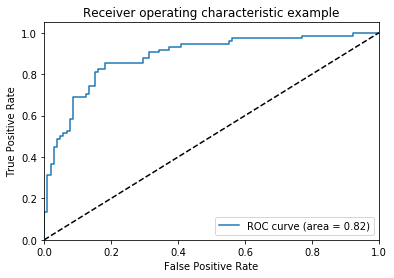

In [27]:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()